# Credit Risk Using Machine Learning


Three components decide the amount of loss that a firm faces as a result of loan default:

* Probability of Default (PD)
* Exposure at Default (EAD)
* Loss given Default (LGD) The expected loss (E-Loss) is the simple product of these three quantities

Expected loss = PD*EAD*LGD

In [26]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import display, Markdown, Latex
import plotly.offline as py 
py.init_notebook_mode(connected=True)                  
import plotly.graph_objs as go                         
import plotly.tools as tls                             
from collections import Counter                        
import plotly.figure_factory as ff
from sklearn.metrics import f1_score
from sklearn.metrics import confusion_matrix, silhouette_score
from sklearn.model_selection import train_test_split, KFold, cross_val_score # to split the data
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, fbeta_score #To evaluate our model
from sklearn.cluster import KMeans
from sklearn.model_selection import GridSearchCV
from sklearn import model_selection
# Algorithmns models to be compared
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from xgboost import XGBClassifier
import warnings
warnings.filterwarnings('ignore')

In [2]:
df = pd.read_csv("german_credit_data.csv", index_col=False)
df.head()

,Unnamed: 0,Age,Sex,Job,Housing,Saving accounts,Checking account,Credit amount,Duration,Purpose,Risk
0,0,67,male,2,own,NaN,little,1169,6,radio/TV,good
1,1,22,female,2,own,little,moderate,5951,48,radio/TV,bad
2,2,49,male,1,own,little,NaN,2096,12,education,good
3,3,45,male,2,free,little,little,7882,42,furniture/equipment,good
4,4,53,male,2,free,little,little,4870,24,car,bad


In [3]:
df.isnull().sum()

Unnamed: 0            0
Age                   0
Sex                   0
Job                   0
Housing               0
Saving accounts     183
Checking account    394
Credit amount         0
Duration              0
Purpose               0
Risk                  0
dtype: int64

In [6]:
df = df.dropna(how='any',axis=0) 

In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 522 entries, 1 to 999
Data columns (total 11 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   Unnamed: 0        522 non-null    int64 
 1   Age               522 non-null    int64 
 2   Sex               522 non-null    object
 3   Job               522 non-null    int64 
 4   Housing           522 non-null    object
 5   Saving accounts   522 non-null    object
 6   Checking account  522 non-null    object
 7   Credit amount     522 non-null    int64 
 8   Duration          522 non-null    int64 
 9   Purpose           522 non-null    object
 10  Risk              522 non-null    object
dtypes: int64(5), object(6)
memory usage: 48.9+ KB


In [8]:
df.describe()

,Unnamed: 0,Age,Job,Credit amount,Duration
count,522.000000,522.000000,522.000000,522.000000,522.000000
mean,493.522989,34.888889,1.875479,3278.745211,21.339080
std,291.131014,11.787918,0.682811,2929.155177,12.474079
min,1.000000,19.000000,0.000000,276.000000,6.000000
25%,233.500000,26.000000,2.000000,1297.500000,12.000000
50%,502.500000,31.500000,2.000000,2326.500000,18.000000
75%,736.750000,41.000000,2.000000,3971.250000,26.750000
max,999.000000,75.000000,3.000000,18424.000000,72.000000


In [9]:
for i in df.columns[1:]:
    #cross table for the features
    cross_df = pd.crosstab(df['Risk'], df[i]).apply(lambda x: x/x.sum() * 100)
    decimals = pd.Series([2,2])
    cross_df = cross_df.round(decimals)
    cross_df_transposed = cross_df.T
    cross_df_transposed.style.background_gradient(cmap='Blues')

# Data Exploration
Let's explore Housing and Risk


In [10]:
#cross table for the 'Sex' feature
cross_owner = pd.crosstab(df['Risk'], df['Job']).apply(lambda x: x/x.sum() * 100)
decimals = pd.Series([2,2])
cross_owner = cross_owner.round(decimals)
cross_owner_transposed = cross_owner.T
cross_owner_transposed.style.background_gradient(cmap='Blues')

Risk,bad,good
Job,,
0,42.860000,57.140000
1,38.790000,61.210000
2,45.686901,54.313099
3,46.835443,53.164557


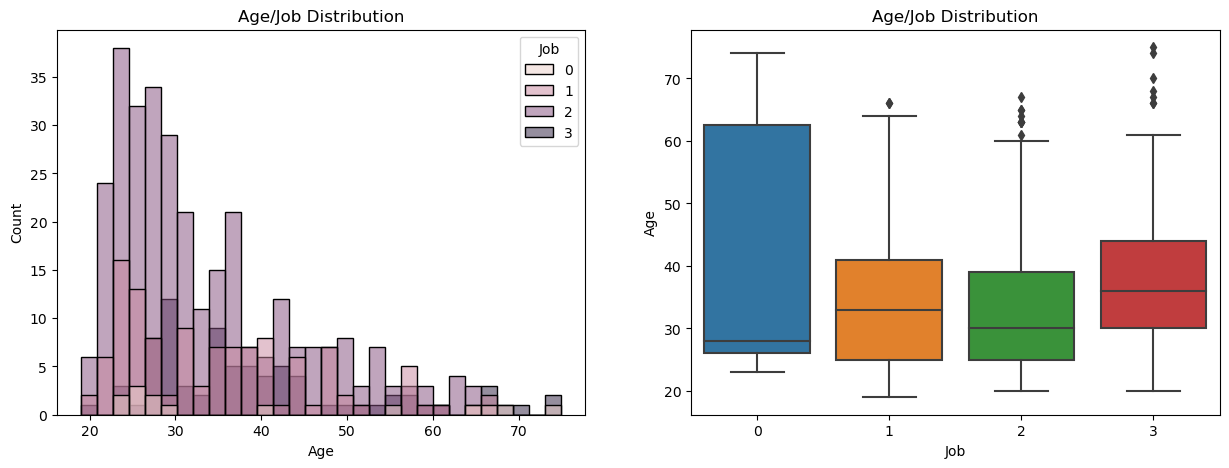

In [11]:
fig, ax = plt.subplots(1,2,figsize=(15,5))
sns.histplot(df, x='Age', bins=30, hue="Job", ax=ax[0]).set_title("Age/Job Distribution");
sns.boxplot(data=df, x="Job", y="Age", ax=ax[1]).set_title("Age/Job Distribution");


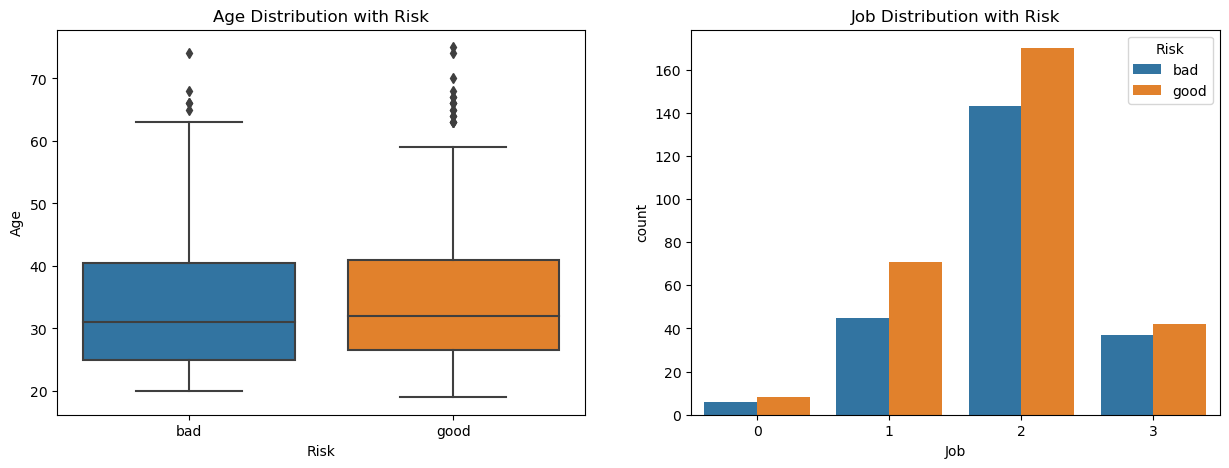

In [12]:
fig, ax = plt.subplots(1,2,figsize=(15,5))
sns.boxplot(data=df, x='Risk', y='Age', ax=ax[0]).set_title("Age Distribution with Risk");
sns.countplot(data=df, x="Job", hue="Risk", ax=ax[1]).set_title("Job Distribution with Risk");


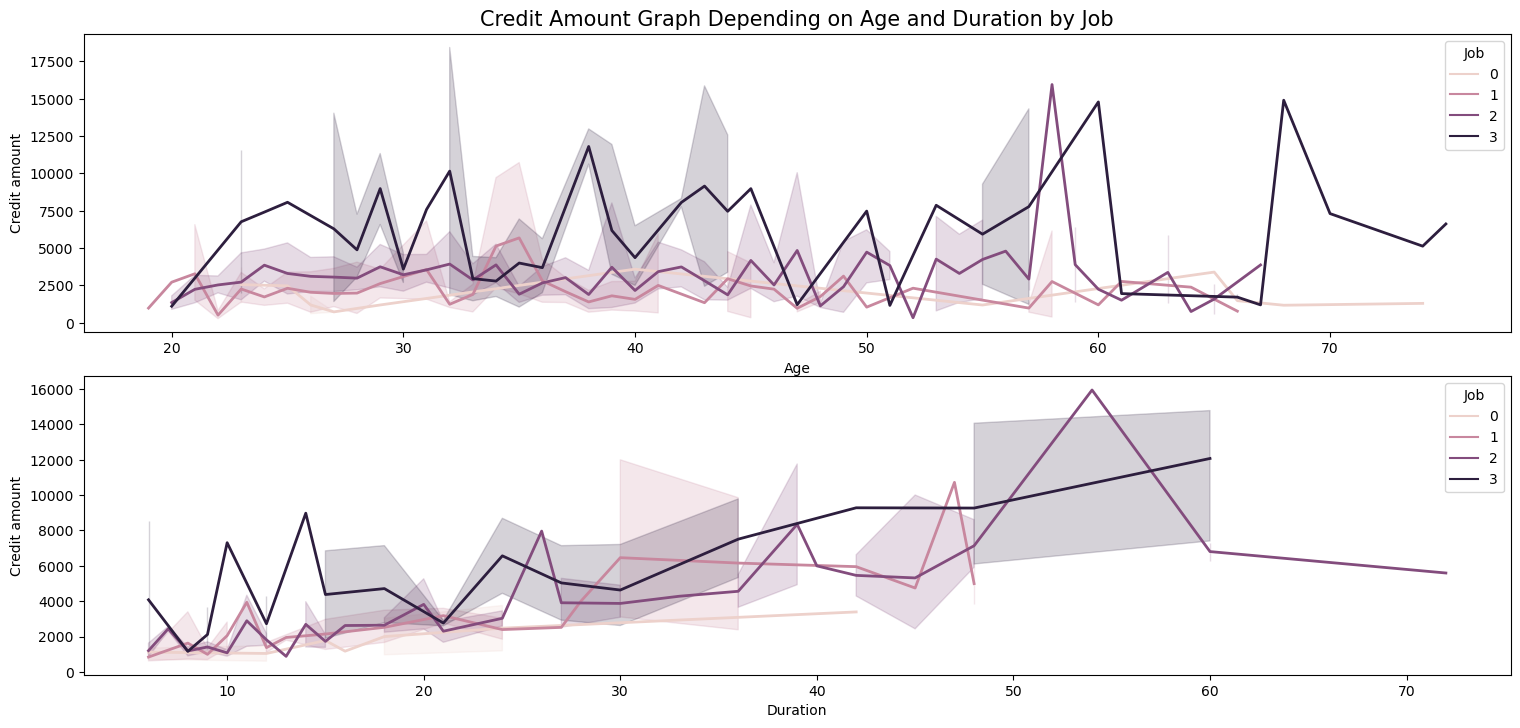

In [13]:
fig, ax = plt.subplots(2,1,figsize=(15,7))
plt.tight_layout()
sns.lineplot(data=df, x='Age', y='Credit amount', hue='Job', lw=2, ax=ax[0]).set_title("Credit Amount Graph Depending on Age and Duration by Job", fontsize=15);
sns.lineplot(data=df, x='Duration', y='Credit amount', hue='Job', lw=2, ax=ax[1]);

In [14]:
df_good = df.loc[df["Risk"] == 'good']['Age'].values.tolist()
df_bad = df.loc[df["Risk"] == 'bad']['Age'].values.tolist()
df_age = df['Age'].values.tolist()

#First plot
trace0 = go.Histogram(
    x=df_good,
    histnorm='probability',
    name="Good Credit",
    marker=dict(
        color='#85ead9'
    )
)
#Second plot
trace1 = go.Histogram(
    x=df_bad,
    histnorm='probability',
    name="Bad Credit",
    marker=dict(
        color='#6f2cea'
    )
)
#Third plot
trace2 = go.Histogram(
    x=df_age,
    histnorm='probability',
    name="Overall Age",
    marker=dict(
        color='#f392f4'
    )
)

#Creating the grid
fig = tls.make_subplots(rows=2, cols=2, specs=[[{}, {}], [{'colspan': 2}, None]],
                          subplot_titles=('Good','Bad', 'General Distribuition'))

#setting the figs
fig.append_trace(trace0, 1, 1)
fig.append_trace(trace1, 1, 2)
fig.append_trace(trace2, 2, 1)

fig['layout'].update(showlegend=True, title='Age Distribuition', bargap=0.05)
py.iplot(fig, filename='custom-sized-subplot-with-subplot-titles')


C:\Users\emefnas\AppData\Local\anaconda3\Lib\site-packages\plotly\tools.py:460: DeprecationWarning:

plotly.tools.make_subplots is deprecated, please use plotly.subplots.make_subplots instead



In [15]:
df_sm = df.copy()
#Let's look the Credit Amount column
df_good = df_sm[df_sm["Risk"] == 'good']
df_bad = df_sm[df_sm["Risk"] == 'bad']


In [16]:
trace0 = go.Box(
    y=df_good["Credit amount"],
    x=df_good["Job"],
    name='Good credit',
    marker=dict(
        color='#50f466'
    )
)

trace1 = go.Box(
    y=df_bad['Credit amount'],
    x=df_bad['Job'],
    name='Bad credit',
    marker=dict(
        color='#b2014e'
    )
)
    
data = [trace0, trace1]

layout = go.Layout(
    yaxis=dict(
        title='Credit Amount (US Dollar)',
        zeroline=False
    ),
    xaxis=dict(
        title='Job Categorical'
    ),
    boxmode='group'
)
fig = go.Figure(data=data, layout=layout)

py.iplot(fig, filename='box-age-cat')

C:\Users\emefnas\AppData\Local\Temp\ipykernel_26220\777313022.py:1: FutureWarning:

The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.



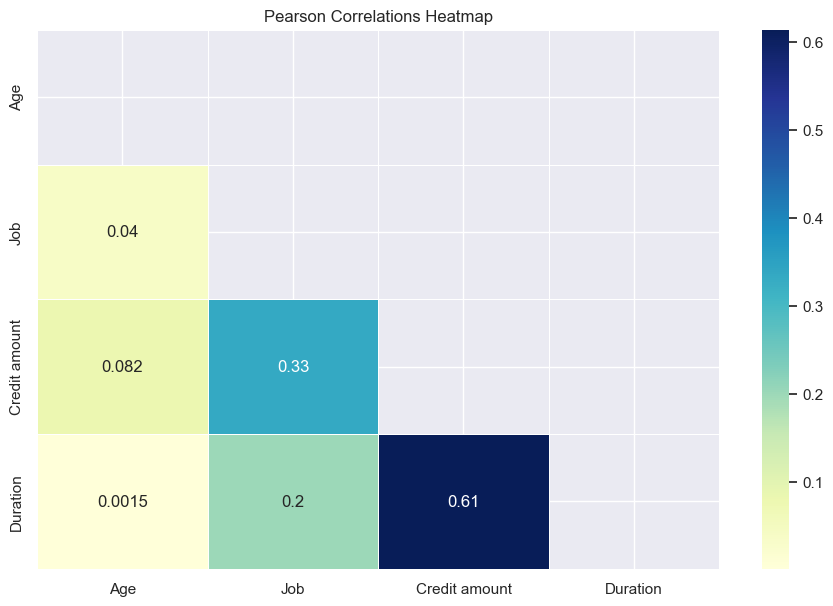

In [17]:
corr = df_sm[['Age', 'Job', 'Housing', 'Saving accounts', 'Checking account', 'Credit amount', 'Duration']].corr()
sns.set(rc={'figure.figsize':(11,7)})
sns.heatmap(corr,linewidths=.5, annot=True, cmap="YlGnBu",mask=np.triu(np.ones_like(corr)))\
    .set_title("Pearson Correlations Heatmap");

In [18]:
display(Markdown("#### Explore the Values of Text Columns:"))
cols = ['Sex', 'Housing', 'Saving accounts', 'Checking account', 'Purpose', 'Risk']
for col in cols:
    line = "**" + col + ":** "
    for v in df[col].unique():
        line = line + str(v) + ", "
    display(Markdown(line))

#### Explore the Values of Text Columns:

**Sex:** female, male, 

**Housing:** own, free, rent, 

**Saving accounts:** little, moderate, quite rich, rich, 

**Checking account:** moderate, little, rich, 

**Purpose:** radio/TV, furniture/equipment, car, business, domestic appliances, repairs, vacation/others, education, 

**Risk:** bad, good, 

In [19]:
# label encode account quality and fill NaN with 0
def SC_LabelEncoder(text):
    if text == "little":
        return 1
    elif text == "moderate":
        return 2
    elif text == "quite rich":
        return 3
    elif text == "rich":
        return 4
    else:
        return 0

def H_LabelEncoder(text):
    if text == "free":
        return 0
    elif text == "rent":
        return 1
    elif text == "own":
        return 2


In [20]:
df["Saving accounts"] = df["Saving accounts"].apply(SC_LabelEncoder)
df["Checking account"] = df["Checking account"].apply(SC_LabelEncoder)
df["Housing"] = df["Housing"].apply(H_LabelEncoder)

In [21]:
# use LabelEncoder() to encode other categorical columns:
from sklearn.preprocessing import LabelEncoder
for col in ["Sex", "Purpose", "Risk", "Age"]:
    le = LabelEncoder()
    le.fit(df[col])
    df[col] = le.transform(df[col])
df.head()

,Unnamed: 0,Age,Sex,Job,Housing,Saving accounts,Checking account,Credit amount,Duration,Purpose,Risk
1,1,3,0,2,2,1,2,5951,48,5,0
3,3,26,1,2,0,1,1,7882,42,4,1
4,4,34,1,2,0,1,1,4870,24,1,0
7,7,16,1,3,1,1,2,6948,36,1,1
9,9,9,1,3,2,1,2,5234,30,1,0


# Kmeans clustering

In [29]:
feature_data = df.drop("Risk", axis=1)
inertias = []
for i in range(2,14):
    kmeans = KMeans(n_clusters=i, random_state=42, n_init = 'auto').fit(feature_data)
    inertias.append(kmeans.inertia_)

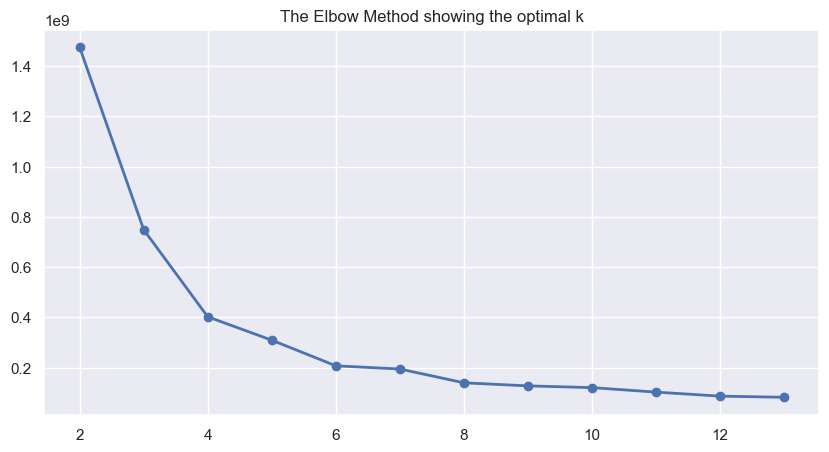

In [30]:
plt.figure(figsize=(10,5))
plt.title('The Elbow Method showing the optimal k')
plt.plot(np.arange(2,14),inertias, marker='o', lw=2);

In [31]:
km = KMeans(n_clusters=4, random_state=42)
clusters = km.fit_predict(feature_data)

In [32]:
acc = max((sum(clusters == df["Risk"]) / len(df)), (sum(clusters != df["Risk"]) / len(df)))
display(Markdown("The accuracy rate of 4-Means clustering is " + str(acc)))

The accuracy rate of 4-Means clustering is 0.7183908045977011

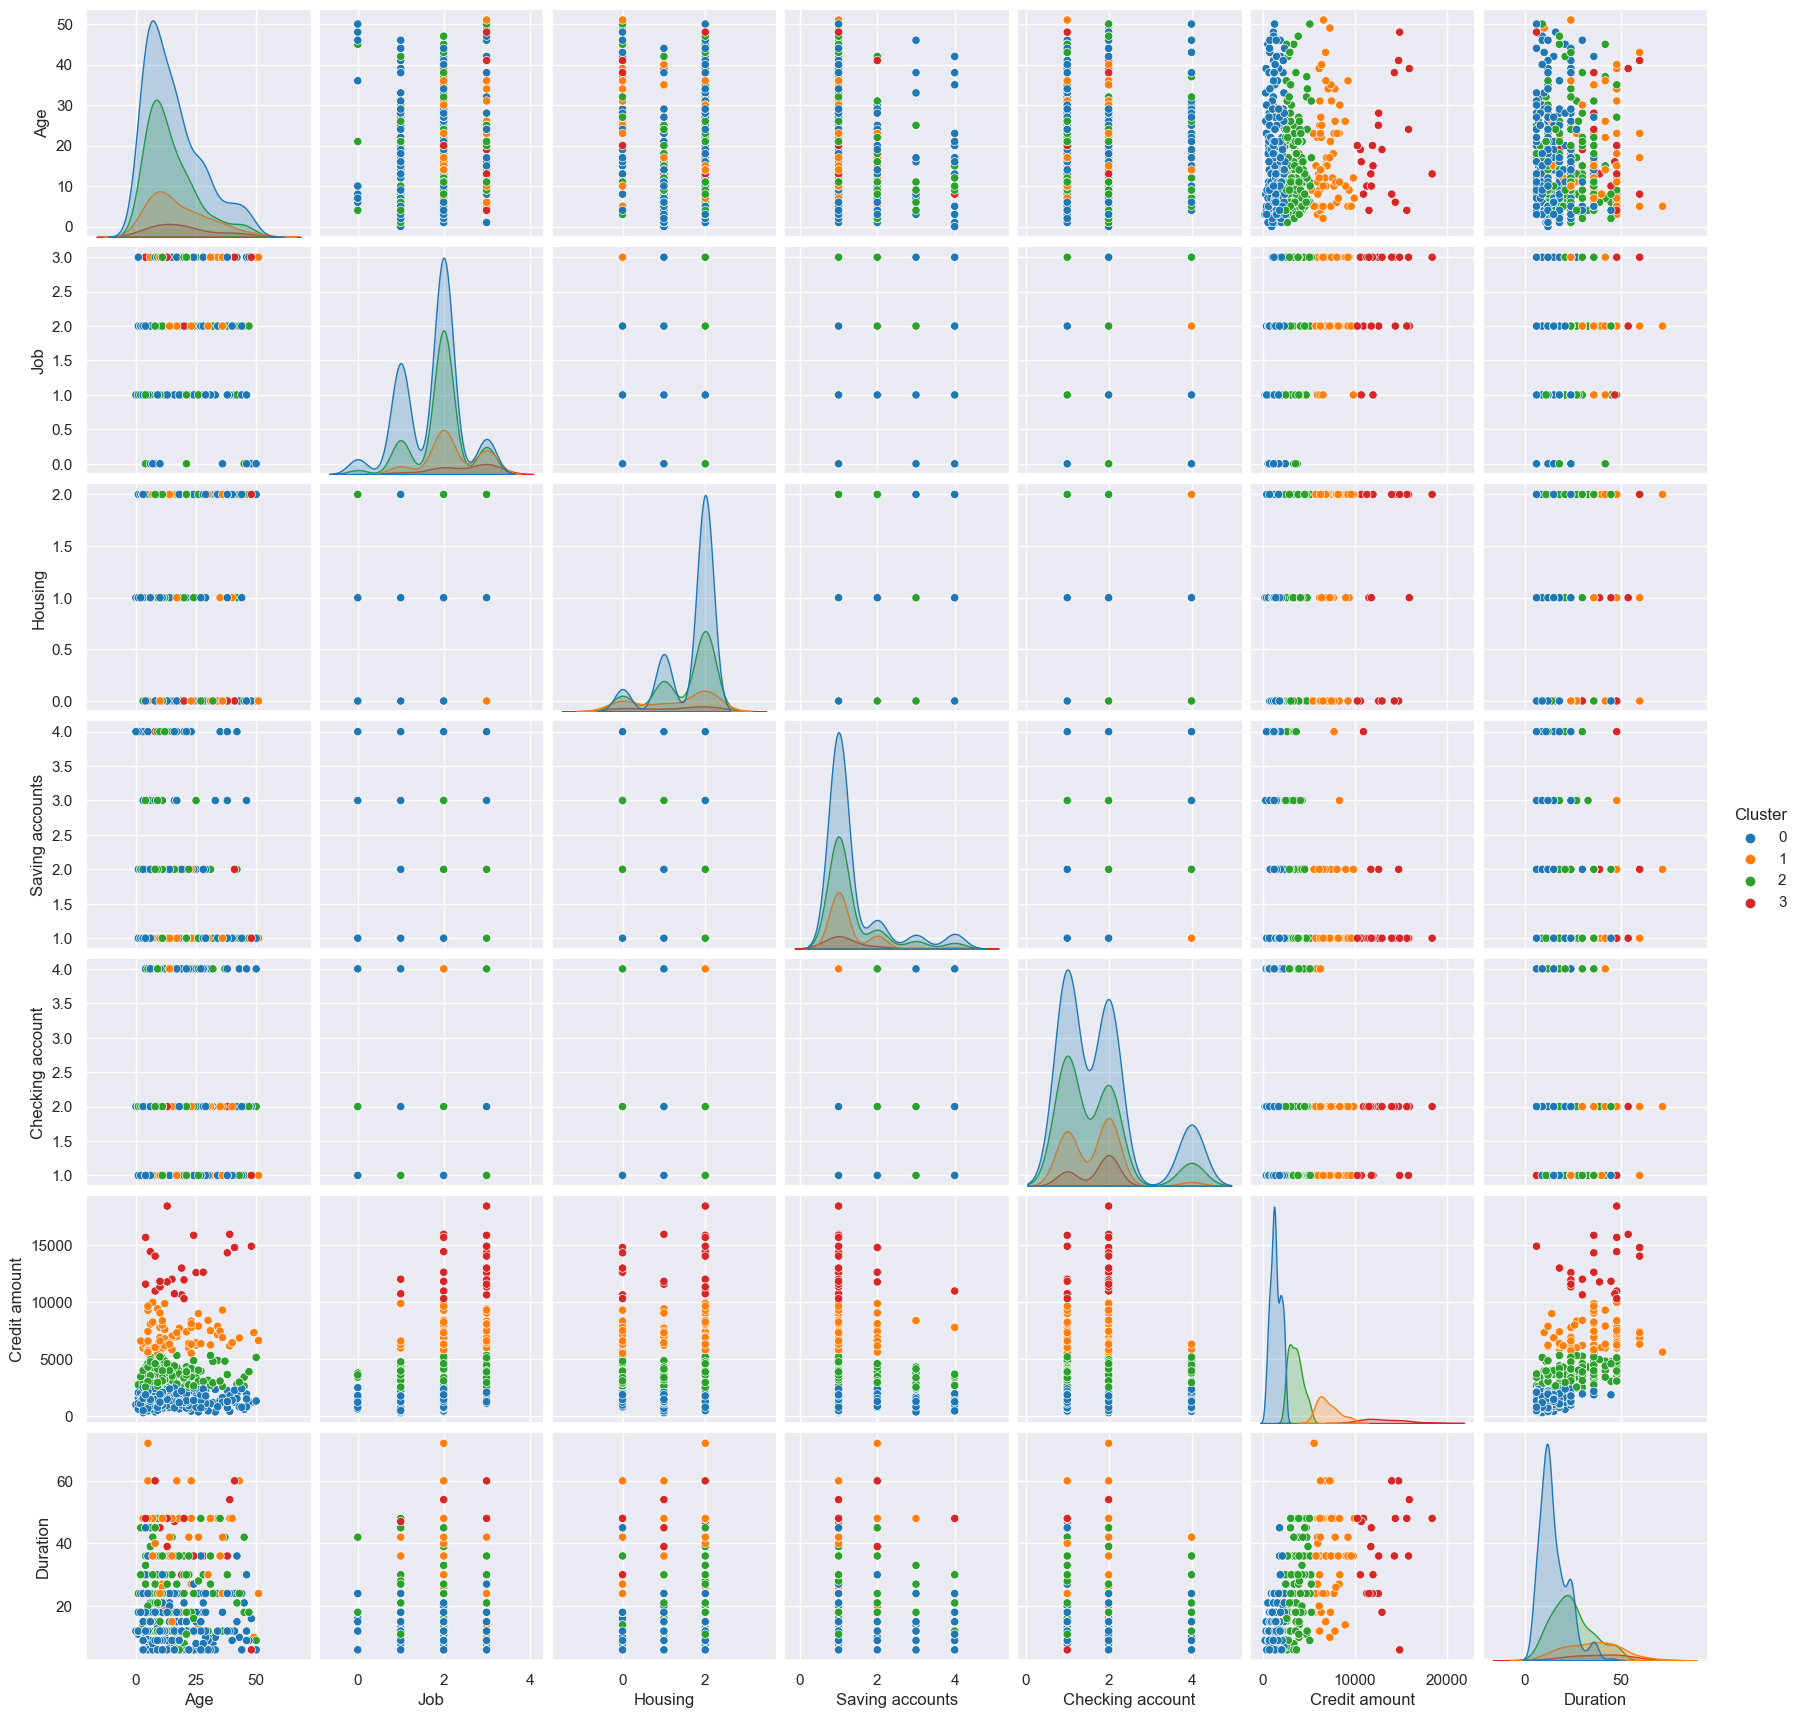

In [33]:
df_clustered = feature_data[['Age', 'Job', 'Housing', 'Saving accounts', 'Checking account', 'Credit amount', 'Duration']]
df_clustered["Cluster"] = clusters
sns.pairplot(df_clustered, hue="Cluster",palette='tab10')

# K-nearest neighbourhood

In [34]:
X, y = df.drop("Risk", axis=1), df["Risk"]
X_train, X_test, y_train, y_test = model_selection.train_test_split(X, y, test_size=0.25, random_state=42)

In [35]:
max_score = 0
max_k = 0
for k in range(1, 100):
    neigh = KNeighborsClassifier(n_neighbors=k)
    neigh.fit(X_train,y_train)
    score = f1_score(y_test, neigh.predict(X_test))
    if score > max_score:
        max_k = k
        max_score = score

display(Markdown("If use K-Nearest Neighbors Classification, the k should be " + str(max_k) + " to get best prediction, and then the  mean accuracy is " + str(max_score)))

If use K-Nearest Neighbors Classification, the k should be 54 to get best prediction, and then the  mean accuracy is 0.7065217391304349

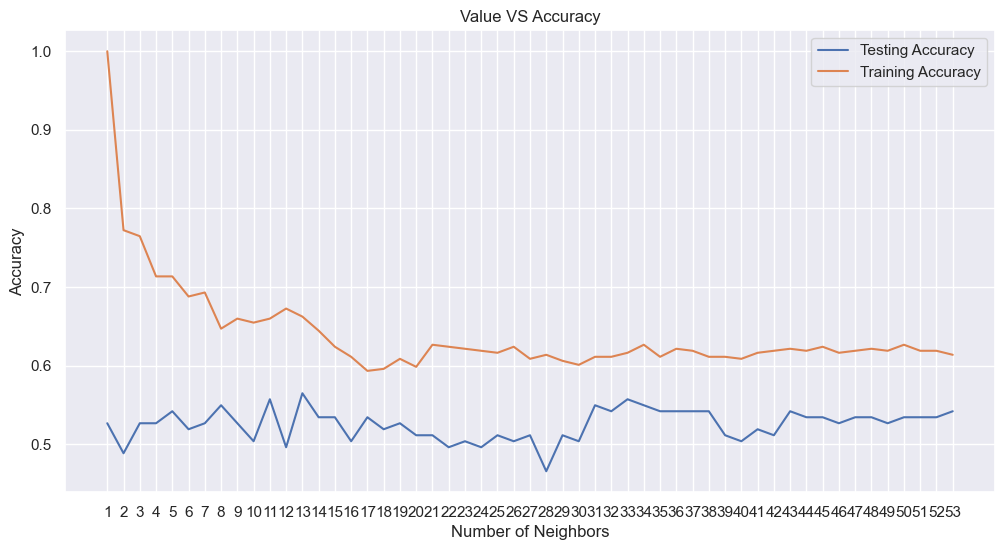

Best accuracy is 0.5648854961832062 with K = 13


In [36]:
neig = np.arange(1, 54)
train_accuracy = []
test_accuracy = []
# Loop over different values of k
for i, k in enumerate(neig):
    # k from 1 to 25(exclude)
    knn_model = KNeighborsClassifier(n_neighbors=k)
    # Fit with knn
    knn_model.fit(X_train,y_train)
    #train accuracy
    train_accuracy.append(knn_model.score(X_train, y_train))
    # test accuracy
    test_accuracy.append(knn_model.score(X_test, y_test))

# Plot
plt.figure(figsize=[12,6])
plt.plot(neig, test_accuracy, label = 'Testing Accuracy')
plt.plot(neig, train_accuracy, label = 'Training Accuracy')
plt.legend()
plt.title('Value VS Accuracy')
plt.xlabel('Number of Neighbors')
plt.ylabel('Accuracy')
plt.xticks(neig)
plt.show()
print("Best accuracy is {} with K = {}".format(np.max(test_accuracy),1+test_accuracy.index(np.max(test_accuracy))))


# Model selection

In [38]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from xgboost import XGBClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from catboost import CatBoostClassifier

In [45]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)


models = {
    "CatBoostClassifier": CatBoostClassifier(verbose=False),
    "XGBClassifier": XGBClassifier(),
    "LogisticRegression": LogisticRegression(),
    "svc": SVC(),
    "DecisionTree": DecisionTreeClassifier(),
    "RandomForest": RandomForestClassifier(),
    "GaussianNaiveBayes": GaussianNB(),
}

# Cross validation

In [48]:
cv_results = pd.DataFrame(columns=['model', 'train_score', 'test_score'])
for key in models.keys():
    cv_res = model_selection.cross_validate(models[key], X_train, y_train, 
                                             return_train_score=True,
                                             scoring="f1",
                                             cv=10, n_jobs=-1)
    res = {
        'model': key, 
        'train_score': cv_res["train_score"].mean(), 
        'test_score': cv_res["test_score"].mean(),
        'fit_time': cv_res["fit_time"].mean(),
        'score_time': cv_res["score_time"].mean()
        }
    cv_results = cv_results.append(res, ignore_index=True)
    print("CV for model:", key, "done.")
cv_results.style.background_gradient(cmap='Blues')

CV for model: CatBoostClassifier done.
CV for model: XGBClassifier done.
CV for model: LogisticRegression done.
CV for model: svc done.
CV for model: DecisionTree done.
CV for model: RandomForest done.
CV for model: GaussianNaiveBayes done.


,model,train_score,test_score,fit_time,score_time
0,CatBoostClassifier,0.970833,0.707556,3.466334,0.004861
1,XGBClassifier,1.000000,0.696342,0.086091,0.014770
2,LogisticRegression,0.732347,0.709021,0.019052,0.009485
3,svc,0.736748,0.730936,0.017946,0.024252
4,DecisionTree,1.000000,0.613046,0.006209,0.002111
5,RandomForest,1.000000,0.704785,0.270547,0.017013
6,GaussianNaiveBayes,0.738241,0.724144,0.008020,0.007962


# Evaluation

The drop from test to train of catboost, xgboost, decision tree and random forest classifiers are large. It seems like the model is overfitting to the training data. The performance of SVC, gaussianNB and logistic are much better on the test data.

In [54]:
from sklearn.inspection import permutation_importance

In [77]:
gaussianNB = models["GaussianNaiveBayes"]
gaussianNB.fit(X_train, y_train)
feature_importance = pd.DataFrame()
feature_importance["feature"] = X_train.columns
pm_importance = permutation_importance(gaussianNB, X_test, y_test, random_state=42,n_repeats = 50)
feature_importance["importance"] = pm_importance.importances_mean
feature_importance = feature_importance.sort_values("importance", ascending=False)
feature_importance


,feature,importance
4,Housing,0.018321
7,Credit amount,0.014962
9,Purpose,0.012672
0,Unnamed: 0,0.011603
1,Age,0.007328
6,Checking account,0.007023
2,Sex,0.002595
5,Saving accounts,0.001527
3,Job,-0.003969
8,Duration,-0.010992


In [80]:
svc_model = models["svc"]
svc_model.fit(X_train, y_train)
feature_importance = pd.DataFrame()
feature_importance["feature"] = X_train.columns
pm_importance = permutation_importance(svc_model, X_test, y_test, random_state=42,n_repeats = 50)
feature_importance["importance"] = pm_importance.importances_mean
feature_importance = feature_importance.sort_values("importance", ascending=False)
feature_importance

,feature,importance
7,Credit amount,0.023206
1,Age,0.000000
2,Sex,0.000000
3,Job,0.000000
4,Housing,0.000000
5,Saving accounts,0.000000
6,Checking account,0.000000
8,Duration,0.000000
9,Purpose,0.000000
0,Unnamed: 0,-0.007176


In [75]:
logistic = models["LogisticRegression"]
logistic.fit(X_train, y_train)
feature_importance = pd.DataFrame()
feature_importance["feature"] = X_train.columns
pm_importance = permutation_importance(logistic, X_test, y_test, random_state=42, n_repeats = 50)
feature_importance["importance"] = pm_importance.importances_mean
feature_importance = feature_importance.sort_values("importance", ascending=False)
feature_importance


,feature,importance
5,Saving accounts,0.024885
4,Housing,0.020458
6,Checking account,0.018473
8,Duration,0.008702
3,Job,0.006107
9,Purpose,0.005649
7,Credit amount,-0.002901
2,Sex,-0.005496
0,Unnamed: 0,-0.008397
1,Age,-0.009771


# Reference
https://www.kaggle.com/code/muhamadsubur/credit-risk-using-machine-learning/notebook